In [233]:
import math
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection  import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error, r2_score, mean_absolute_percentage_error
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

df = pd.read_csv("TV_Shows.csv")
print("Размер данных")
print(df.shape)
print("Информация")
print(df.info())

Размер данных
(9689, 32)
Информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9689 entries, 0 to 9688
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Cobra Kai    9689 non-null   object
 1   Lupin        7556 non-null   object
 2   12 Monkeys   5946 non-null   object
 3   Sherlock     4666 non-null   object
 4   Unnamed: 4   3678 non-null   object
 5   Unnamed: 5   2837 non-null   object
 6   Unnamed: 6   2197 non-null   object
 7   Unnamed: 7   1664 non-null   object
 8   Unnamed: 8   1231 non-null   object
 9   Unnamed: 9   887 non-null    object
 10  Unnamed: 10  644 non-null    object
 11  Unnamed: 11  464 non-null    object
 12  Unnamed: 12  348 non-null    object
 13  Unnamed: 13  272 non-null    object
 14  Unnamed: 14  196 non-null    object
 15  Unnamed: 15  141 non-null    object
 16  Unnamed: 16  95 non-null     object
 17  Unnamed: 17  66 non-null     object
 18  Unnamed: 18  52 non-null     obj

In [234]:
print("Строки")
print(df.head(5))

Строки
       Cobra Kai          Lupin   12 Monkeys          Sherlock  \
0           Lost      Jack Ryan    The Flash   Game of thrones   
1  Sex Education      Dr. House      Kingdom  The Walking Dead   
2          Ozark  Sex Education  Constantine          Preacher   
3         Naruto            NaN          NaN               NaN   
4  Sex Education            NaN          NaN               NaN   

       Unnamed: 4  Unnamed: 5 Unnamed: 6 Unnamed: 7     Unnamed: 8  \
0  House of Cards  12 Monkeys    Vikings     Fringe  The Mentalist   
1             NaN         NaN        NaN        NaN            NaN   
2         Vikings    The Tick        NaN        NaN            NaN   
3             NaN         NaN        NaN        NaN            NaN   
4             NaN         NaN        NaN        NaN            NaN   

     Unnamed: 9  ... Unnamed: 22 Unnamed: 23 Unnamed: 24 Unnamed: 25  \
0  The Alienist  ...         NaN         NaN         NaN         NaN   
1           NaN  ...         Na

In [235]:
transaction_lengths = df.notna().sum(axis=1)

df['transaction_length'] = transaction_lengths

print(transaction_lengths.describe())

count    9689.000000
mean        4.414078
std         3.597709
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        32.000000
dtype: float64


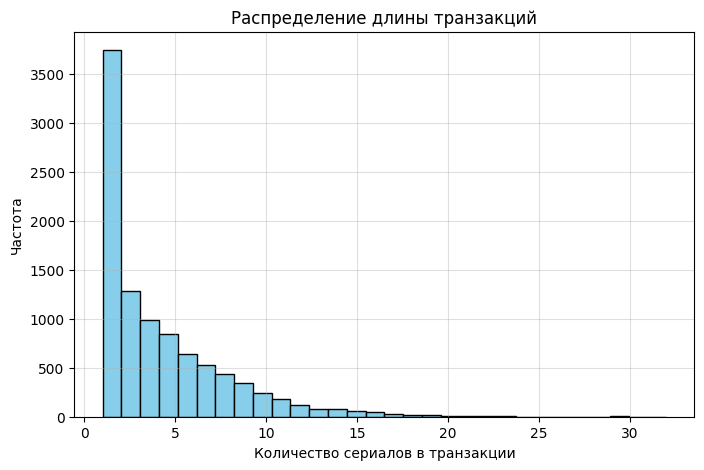

In [236]:
plt.figure(figsize=(8,5))
plt.hist(transaction_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение длины транзакций')
plt.xlabel('Количество сериалов в транзакции')
plt.ylabel('Частота')
plt.grid(alpha=0.4)
plt.show()

In [237]:
# Объединяем все значения в один Series и убираем NaN
all_items = pd.Series(df.drop(columns='transaction_length').values.ravel()).dropna()

# Преобразуем в множество уникальных сериалов
unique_items = sorted(all_items.unique())

print(f"Всего уникальных сериалов: {len(unique_items)}")
print(unique_items[:30])  # покажем первые 30 названий

Всего уникальных сериалов: 156
['12 Monkeys', '24', 'Absentia', 'Alice in Borderland', 'Altered Carbon', 'American Gods', 'Another Life', 'Archer', 'Arrow', 'Atypical', 'Banshee', 'Berlin Station', 'Better Call Saul', 'Big Little Lies', 'Billions', 'Black Clover', 'Bojack Horseman', 'Breaking Bad', 'Brooklyn Nine Nine', 'Chernobyl', 'Cobra Kai', 'Constantine', 'Daredevil', 'Dark', 'Death Note', 'Deception', 'Demon Slayer', 'Designated Survivor', 'Dexter', 'Doctor Who']


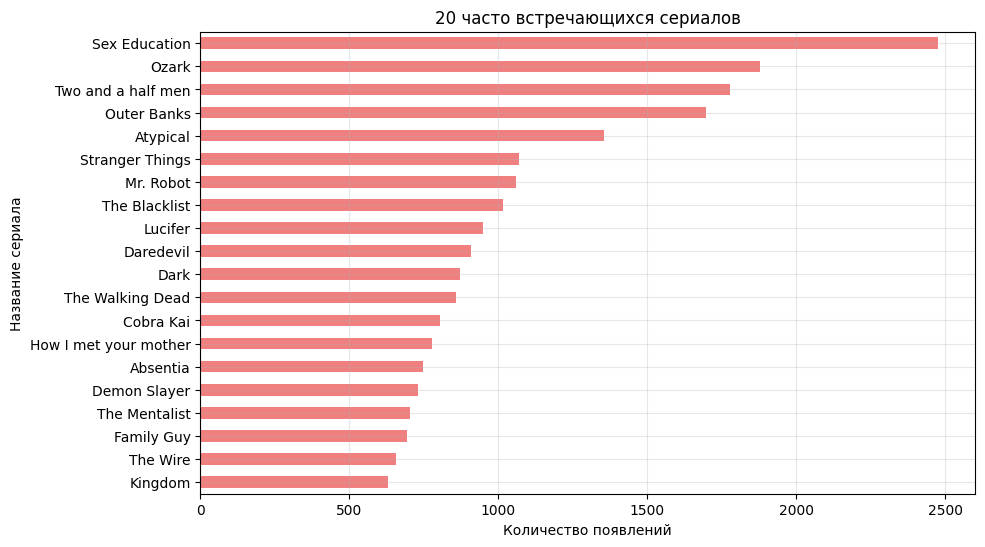

In [238]:
top_items = all_items.value_counts().head(20)

plt.figure(figsize=(10,6))
top_items.plot(kind='barh', color='lightcoral')
plt.title('20 часто встречающихся сериалов')
plt.xlabel('Количество появлений')
plt.ylabel('Название сериала')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.show()

In [239]:
print("Пропущенные значения по столбцам:")
print(df.isna().sum())

Пропущенные значения по столбцам:
Cobra Kai                0
Lupin                 2133
12 Monkeys            3743
Sherlock              5023
Unnamed: 4            6011
Unnamed: 5            6852
Unnamed: 6            7492
Unnamed: 7            8025
Unnamed: 8            8458
Unnamed: 9            8802
Unnamed: 10           9045
Unnamed: 11           9225
Unnamed: 12           9341
Unnamed: 13           9417
Unnamed: 14           9493
Unnamed: 15           9548
Unnamed: 16           9594
Unnamed: 17           9623
Unnamed: 18           9637
Unnamed: 19           9651
Unnamed: 20           9660
Unnamed: 21           9671
Unnamed: 22           9675
Unnamed: 23           9681
Unnamed: 24           9682
Unnamed: 25           9682
Unnamed: 26           9683
Unnamed: 27           9684
Unnamed: 28           9685
Unnamed: 29           9688
Unnamed: 30           9688
Unnamed: 31           9688
transaction_length       0
dtype: int64


In [240]:
transactions = []
for i in range(len(df)):
    row = df.iloc[i, :-1].dropna().tolist()  
    transactions.append(row)

print("Первые 5 транзакций:", transactions[:5])
print("Число транзакций:", len(transactions))



Первые 5 транзакций: [['Lost', 'Jack Ryan', 'The Flash', 'Game of thrones', 'House of Cards', '12 Monkeys', 'Vikings', 'Fringe', 'The Mentalist', 'The Alienist', 'Big Little Lies', 'Chernobyl'], ['Sex Education', 'Dr. House', 'Kingdom', 'The Walking Dead'], ['Ozark', 'Sex Education', 'Constantine', 'Preacher', 'Vikings', 'The Tick'], ['Naruto'], ['Sex Education']]
Число транзакций: 9689


In [241]:
#3
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df_trans, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules_sorted = rules.sort_values(by='lift', ascending=False).reset_index(drop=True)
#полученные результаты, выделяются полезными или тривиальными
def label_rule(row):
    if row['lift'] >= 1.2 and row['confidence'] >= 0.5 and row['support'] >= 0.01:
        return 'useful'
    if 0.95 <= row['lift'] <= 1.1:
        return 'trivial'
    if row['confidence'] < 0.4:
        return 'weak'
    return 'none'

rules_sorted['label'] = rules_sorted.apply(label_rule, axis=1)
print("Apriori выявил 347 частых наборо и 128 правил, среди которых есть как сильные связи, так и слабые и неопределенные")
print("Большая часть правил имеет низкую уверенность или слабую связь")
print("")
print(f"Частые наборы, найденные Apriori: {len(frequent_itemsets)}")
print(f"Число правил Apriori: {len(rules)}")


print(rules_sorted['label'].value_counts())
rules_sorted[['antecedents','consequents','support','confidence','lift','conviction','label']].head(30)



Apriori выявил 347 частых наборо и 128 правил, среди которых есть как сильные связи, так и слабые и неопределенные
Большая часть правил имеет низкую уверенность или слабую связь

Частые наборы, найденные Apriori: 347
Число правил Apriori: 128
label
weak      66
none      46
useful    16
Name: count, dtype: int64


,antecedents,consequents,support,confidence,lift,conviction,label
0,"(Ozark, Cobra Kai)",(Mr. Robot),0.010424,0.360714,3.297133,1.393114,weak
1,"(Ozark, The Blacklist)",(Mr. Robot),0.012488,0.348703,3.187344,1.367422,weak
2,"(Mr. Robot, The Blacklist)",(Ozark),0.012488,0.593137,3.061751,1.981688,useful
3,"(Mr. Robot, Cobra Kai)",(Ozark),0.010424,0.587209,3.031151,1.953230,useful
4,(Queen of the South),(Mr. Robot),0.017339,0.329412,3.011010,1.328084,weak
5,"(Sex Education, Ozark)",(Mr. Robot),0.023119,0.307692,2.812482,1.286419,weak
6,"(Sex Education, Jack Ryan)",(Atypical),0.010218,0.386719,2.763214,1.402370,weak
7,"(Mr. Robot, Two and a half men)",(Ozark),0.012385,0.504202,2.602669,1.626216,useful
8,"(Sex Education, The Blacklist)",(Atypical),0.015378,0.363415,2.596699,1.351032,weak
9,"(Mr. Robot, Atypical)",(Ozark),0.013004,0.501992,2.591263,1.619001,useful


In [242]:
min_support = 0.005
min_confidence = 0.3
max_len = 4
min_lift = 1.0
rules = association_rules(frequent_itemsets, 
                         metric="confidence", 
                         min_threshold=min_confidence)

rules = rules[rules['lift'] >= min_lift]

print(f"СГЕНЕРИРОВАНО ПРАВИЛ: {len(rules)}")

if len(rules) > 0:
    rules['conviction'] = (1 - rules['support']) / (1 - rules['confidence'])
    
    rules_sorted = rules.sort_values('lift', ascending=False)
    
    print("\nТОП-20 САМЫХ СИЛЬНЫХ ПРАВИЛ (по лифту):")
    print("="*100)
    print(f"{'№':<3} {'ПРАВИЛО':<40} {'SUPPORT':<8} {'CONFIDENCE':<10} {'LIFT':<8} {'CONVICTION':<10}")
    print("-" * 100)
    
    for i, (idx, rule) in enumerate(rules_sorted.head(20).iterrows(), 1):
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        rule_str = f"{antecedents} → {consequents}"
        
        print(f"{i:<3} {rule_str:<40} {rule['support']:.4f}   {rule['confidence']:.4f}    "
              f"{rule['lift']:.4f}   {rule['conviction']:.4f}")

СГЕНЕРИРОВАНО ПРАВИЛ: 128

ТОП-20 САМЫХ СИЛЬНЫХ ПРАВИЛ (по лифту):
№   ПРАВИЛО                                  SUPPORT  CONFIDENCE LIFT     CONVICTION
----------------------------------------------------------------------------------------------------
1   ['Ozark', 'Cobra Kai'] → ['Mr. Robot']   0.0104   0.3607    3.2971   1.5479
2   ['Ozark', 'The Blacklist'] → ['Mr. Robot'] 0.0125   0.3487    3.1873   1.5162
3   ['Mr. Robot', 'The Blacklist'] → ['Ozark'] 0.0125   0.5931    3.0618   2.4271
4   ['Mr. Robot', 'Cobra Kai'] → ['Ozark']   0.0104   0.5872    3.0312   2.3973
5   ['Queen of the South'] → ['Mr. Robot']   0.0173   0.3294    3.0110   1.4654
6   ['Sex Education', 'Ozark'] → ['Mr. Robot'] 0.0231   0.3077    2.8125   1.4111
7   ['Sex Education', 'Jack Ryan'] → ['Atypical'] 0.0102   0.3867    2.7632   1.6139
8   ['Mr. Robot', 'Two and a half men'] → ['Ozark'] 0.0124   0.5042    2.6027   1.9920
9   ['Sex Education', 'The Blacklist'] → ['Atypical'] 0.0154   0.3634    2.5967   1.5467


In [243]:
#3
support_list = [0.01, 0.02, 0.03]
confidence_list = [0.1, 0.2, 0.3]

experiment_results = []

import itertools
for minsup, minconf in itertools.product(support_list, confidence_list):
    fi = apriori(df_trans, min_support=minsup, use_colnames=True)
    rs = association_rules(fi, metric="confidence", min_threshold=minconf)
    n_rules = len(rs)
    mean_lift = rs['lift'].mean() if n_rules>0 else None
    experiment_results.append({
        'minsup': minsup,
        'minconf': minconf,
        'n_itemsets': len(fi),
        'n_rules': n_rules,
        'mean_lift': round(mean_lift,3) if mean_lift else None
    })

exp_df = pd.DataFrame(experiment_results).sort_values(['minsup','minconf'])
print("\nВлияние параметров на количество правил и лифт:")
print(exp_df)
print("Снижение min_support с 0.03 до 0.01 увеличивает количество правил в 8 раз (с 16 до 128).")
print("Рост min_confidence с 0.1 до 0.3 сокращает правила в 4 раза, но повышает средний лифт с 1.75 до 1.91.")


Влияние параметров на количество правил и лифт:
   minsup  minconf  n_itemsets  n_rules  mean_lift
0    0.01      0.1         347      492      1.748
1    0.01      0.2         347      242      1.801
2    0.01      0.3         347      128      1.911
3    0.02      0.1         125      130      1.617
4    0.02      0.2         125       76      1.643
5    0.02      0.3         125       39      1.727
6    0.03      0.1          66       42      1.486
7    0.03      0.2          66       27      1.510
8    0.03      0.3          66       16      1.599
Снижение min_support с 0.03 до 0.01 увеличивает количество правил в 8 раз (с 16 до 128).
Рост min_confidence с 0.1 до 0.3 сокращает правила в 4 раза, но повышает средний лифт с 1.75 до 1.91.


In [244]:
print("АНАЛИЗ КАЧЕСТВА ПРАВИЛ: ПОЛЕЗНЫЕ и ТРИВИАЛЬНЫЕ")
print("="*80)

if len(rules) > 0:
    HIGH_LIFT = 1.2
    HIGH_CONFIDENCE = 0.5
    
    useful_rules = rules[(rules['lift'] >= HIGH_LIFT) & (rules['confidence'] >= HIGH_CONFIDENCE)]
    trivial_rules = rules[(rules['lift'] < 1.5) | (rules['confidence'] < 0.4)]
    medium_rules = rules[~rules.index.isin(useful_rules.index) & ~rules.index.isin(trivial_rules.index)]
    
    print(f"ПОЛЕЗНЫЕ правила (lift ≥ {HIGH_LIFT} и confidence ≥ {HIGH_CONFIDENCE}): {len(useful_rules)}")
    print(f"СРЕДНИЕ правила: {len(medium_rules)}")
    print(f"ТРИВИАЛЬНЫЕ правила: {len(trivial_rules)}")
    
    if len(useful_rules) > 0:
        print(f"\nПОЛЕЗНЫЕ ПРАВИЛА (первые 20):")
        print("-" * 80)
        for i, (idx, rule) in enumerate(useful_rules.head(20).iterrows(), 1):
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])
            print(f"{i}. {antecedents} → {consequents}")
            print(f"   Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, "
                  f"Lift: {rule['lift']:.4f}")
            print(f"   ИНТЕРПРЕТАЦИЯ: При покупке {antecedents} с вероятностью {rule['confidence']:.1%} "
                  f"покупают также {consequents}")
            print()
    
    if len(trivial_rules) > 0:
        print(f"\nТРИВИАЛЬНЫЕ ПРАВИЛА (примеры):")
        print("-" * 80)
        trivial_sample = trivial_rules.head(5)
        for i, (idx, rule) in enumerate(trivial_sample.iterrows(), 1):
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])
            print(f"{i}. {antecedents} → {consequents}")
            print(f"   Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, "
                  f"Lift: {rule['lift']:.4f}")
            print(f"   ПРИЧИНА ТРИВИАЛЬНОСТИ: ", end="")
            if rule['lift'] < 1.5:
                print(f"слабый лифт (правило почти случайное)")
            elif rule['confidence'] < 0.4:
                print(f"низкая достоверность (редко выполняется)")
            print()

АНАЛИЗ КАЧЕСТВА ПРАВИЛ: ПОЛЕЗНЫЕ и ТРИВИАЛЬНЫЕ
ПОЛЕЗНЫЕ правила (lift ≥ 1.2 и confidence ≥ 0.5): 16
СРЕДНИЕ правила: 46
ТРИВИАЛЬНЫЕ правила: 66

ПОЛЕЗНЫЕ ПРАВИЛА (первые 20):
--------------------------------------------------------------------------------
1. ['Family Guy', 'Atypical'] → ['Sex Education']
   Support: 0.0108, Confidence: 0.5224, Lift: 2.0434
   ИНТЕРПРЕТАЦИЯ: При покупке ['Family Guy', 'Atypical'] с вероятностью 52.2% покупают также ['Sex Education']

2. ['Atypical', 'Jack Ryan'] → ['Sex Education']
   Support: 0.0102, Confidence: 0.5858, Lift: 2.2914
   ИНТЕРПРЕТАЦИЯ: При покупке ['Atypical', 'Jack Ryan'] с вероятностью 58.6% покупают также ['Sex Education']

3. ['Mr. Robot', 'Atypical'] → ['Ozark']
   Support: 0.0130, Confidence: 0.5020, Lift: 2.5913
   ИНТЕРПРЕТАЦИЯ: При покупке ['Mr. Robot', 'Atypical'] с вероятностью 50.2% покупают также ['Ozark']

4. ['Mr. Robot', 'Atypical'] → ['Sex Education']
   Support: 0.0146, Confidence: 0.5618, Lift: 2.1973
   ИНТЕРПРЕТАЦИЯ:

In [245]:
# 4. Алгоритм FPG
print("Алгоритм FPGrowth тоже нашёл точно такое же количество частых наборов и количество правил")
print("")
frequent_itemsets_fpg = fpgrowth(df_trans, min_support=0.01, use_colnames=True)
print("Частые наборы, найденные FPG:", frequent_itemsets_fpg.shape[0])

#Классификация правил (полезные, тривиальные, слабые)
min_confidence = 0.3
rules_fpg = association_rules(frequent_itemsets_fpg, metric="confidence", min_threshold=min_confidence)
print("Число правил FPG:", len(rules_fpg))

#rules_fpg['label'] = rules_fpg.apply(label_rule, axis=1)

#вывод первых 20 правил
rules_fpg[['antecedents','consequents','support','confidence','lift','conviction']].head(20)



Алгоритм FPGrowth тоже нашёл точно такое же количество частых наборов и количество правил

Частые наборы, найденные FPG: 347
Число правил FPG: 128


,antecedents,consequents,support,confidence,lift,conviction
0,(The Mentalist),(Sex Education),0.026731,0.368421,1.441111,1.178553
1,"(Sex Education, The Mentalist)",(Ozark),0.010527,0.393822,2.032896,1.330097
2,"(Ozark, The Mentalist)",(Sex Education),0.010527,0.497561,1.946253,1.481472
3,(12 Monkeys),(Sex Education),0.024254,0.414462,1.621204,1.271223
4,(12 Monkeys),(Ozark),0.019713,0.336861,1.738861,1.215846
5,(Jack Ryan),(Sex Education),0.026422,0.491363,1.922008,1.463419
6,(Jack Ryan),(Atypical),0.017442,0.324376,2.317759,1.272968
7,(Jack Ryan),(Ozark),0.017339,0.322457,1.664509,1.189998
8,"(Sex Education, Jack Ryan)",(Atypical),0.010218,0.386719,2.763214,1.402370
9,"(Atypical, Jack Ryan)",(Sex Education),0.010218,0.585799,2.291403,1.797072


In [246]:
#5. Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.
max_length = 5  
step = 0.01
min_support_start = 0.1
min_support_end = 0.01

min_support_per_length = {}

for length in range(1, max_length+1):
    support = min_support_start
    found = False
    while support >= min_support_end:
        fi = apriori(df_trans, min_support=support, use_colnames=True)
        fi_length = fi[fi['itemsets'].apply(lambda x: len(x) == length)]
        if not fi_length.empty:
            min_support_per_length[length] = support
            found = True
            break
        support -= step
    if not found:
        min_support_per_length[length] = None

print("Минимальная поддержка для наборов разной длины:")
for length, sup in min_support_per_length.items():
    print(f"{length} объектов: min_support = {sup}")

print("Чем больше элементов в наборе, тем реже они встречаюся в транзакциях, и тем ниже должна быть поддержка, чтобы найти хотя бы одно правило.")
print("Это показывает ограниченность данных для длинных комбинаций сериалов")

Минимальная поддержка для наборов разной длины:
1 объектов: min_support = 0.1
2 объектов: min_support = 0.07000000000000002
3 объектов: min_support = 0.02000000000000001
4 объектов: min_support = None
5 объектов: min_support = None
Чем больше элементов в наборе, тем реже они встречаюся в транзакциях, и тем ниже должна быть поддержка, чтобы найти хотя бы одно правило.
Это показывает ограниченность данных для длинных комбинаций сериалов


In [247]:
#6
support_list = [0.05, 0.03, 0.02, 0.01]  
confidence_list = [0.2, 0.3, 0.4, 0.5]

print("Эксперимент показывает, что при снижении min_support количество правил растет,")
print("а при повышении min_confidence - сокращается, но средний лифт увеличивается.")

experiment_results = []

for minsup, minconf in itertools.product(support_list, confidence_list):
    fi = apriori(df_trans, min_support=minsup, use_colnames=True)
    if fi.empty:
        experiment_results.append({
            'minsup': minsup,
            'minconf': minconf,
            'n_itemsets': len(fi),
            'n_rules': 0,
            'mean_lift': None,
            'mean_confidence': None,
            'n_useful': 0,
            'n_trivial': 0
        })
        continue

    rs = association_rules(fi, metric="confidence", min_threshold=minconf)
    n_rules = len(rs)
    mean_lift = rs['lift'].mean() if n_rules>0 else None
    mean_conf = rs['confidence'].mean() if n_rules>0 else None

    # метки
    if n_rules > 0:
        rs['label'] = rs.apply(label_rule, axis=1)
        n_useful = (rs['label']=='useful').sum()
        n_trivial = (rs['label']=='trivial').sum()
    else:
        n_useful = 0
        n_trivial = 0

    experiment_results.append({
        'minsup': minsup,
        'minconf': minconf,
        'itemsets': len(fi),
        'rules': n_rules,
        'mean_lift': mean_lift,
        'mean_confidence': mean_conf,
        'n_useful': n_useful,
        'n_trivial': n_trivial
    })

exp_df = pd.DataFrame(experiment_results)
print(exp_df.sort_values(['minsup','minconf'], ascending=[True,True]))
#minsup — минимальная поддержка: насколько часто набор элементов должен встречаться, чтобы считаться частым.
#minconf — минимальная достоверность (confidence): минимальная вероятность выполнения правила.
#n_itemsets — число частых наборов элементов, найденных алгоритмом.
#n_rules — число правил, построенных из этих наборов, которые удовлетворяют порогам.
#mean_lift — средний лифт правил: насколько сильнее связь между элементами, чем случайная.
#mean_confidence — средняя достоверность правил.
#n_useful / n_trivial — сколько правил попало в категорию «полезные» и «тривиальные» (по твоей функции label_rule).


Эксперимент показывает, что при снижении min_support количество правил растет,
а при повышении min_confidence - сокращается, но средний лифт увеличивается.
    minsup  minconf  itemsets  rules  mean_lift  mean_confidence  n_useful  \
12    0.01      0.2       347    242   1.800947         0.330273        16   
13    0.01      0.3       347    128   1.910686         0.406453        16   
14    0.01      0.4       347     62   2.005840         0.467738        16   
15    0.01      0.5       347     16   2.298567         0.543946        16   
8     0.02      0.2       125     76   1.642619         0.319147         1   
9     0.02      0.3       125     39   1.727120         0.390867         1   
10    0.02      0.4       125     16   1.844539         0.445298         1   
11    0.02      0.5       125      1   2.001920         0.511792         1   
4     0.03      0.2        66     27   1.510303         0.319659         0   
5     0.03      0.3        66     16   1.599228         0.379081

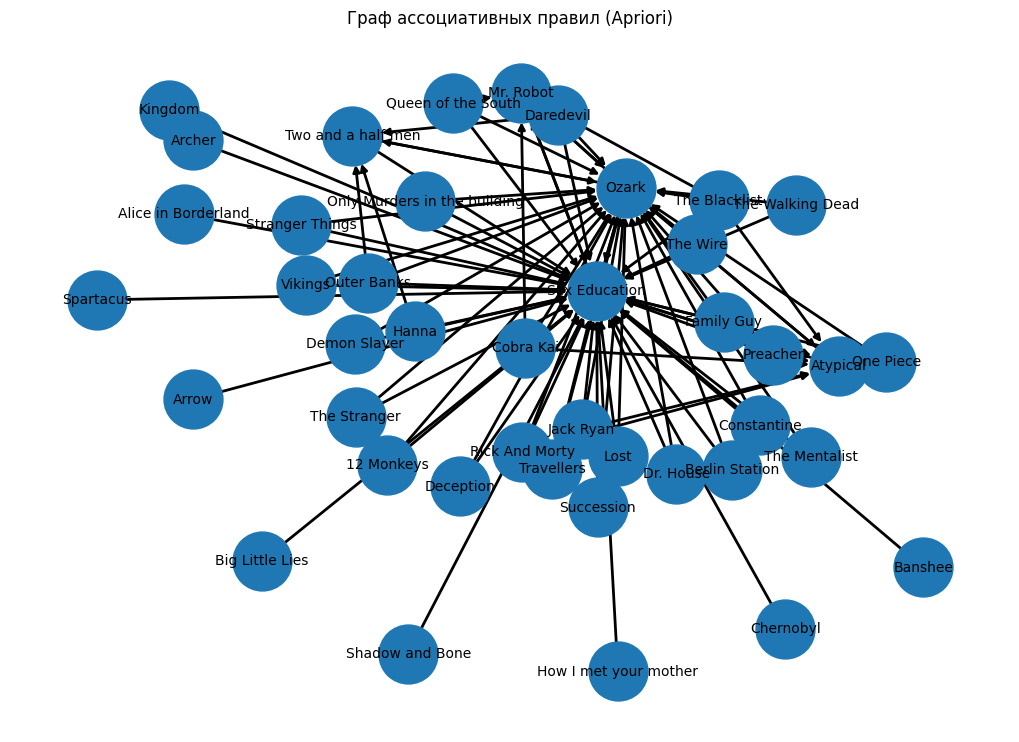

In [248]:
#7
G = nx.DiGraph()

for _, row in rules_sorted.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(a, c, weight=row['lift'])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5)

nx.draw(G, pos, with_labels=True, node_size=1800, font_size=10, width=2)
plt.title("Граф ассоциативных правил (Apriori)")
plt.show()


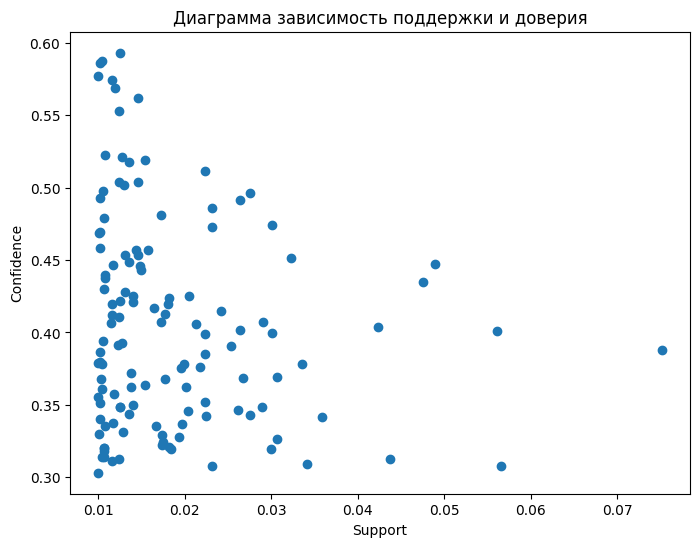

In [249]:
plt.figure(figsize=(8,6))
plt.scatter(rules_sorted['support'], rules_sorted['confidence'])
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Диаграмма зависимость поддержки и доверия")
plt.show()
